## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import seaborn as sns
from itertools import chain
from skimage.io import imread,imshow
import matplotlib.image as mpimg #read png files
from scipy.ndimage import gaussian_filter
import scipy
from random import sample
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten,Conv2D,MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

pd.set_option('display.max_columns', None)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
15254  00003997_001.png       Effusion            1        3997           76   
4041   00001101_001.png     No Finding            1        1101           45   
87437  00021604_000.png   Infiltration            0       21604           24   

      Patient Gender View Position  OriginalImage[Width  Height]  \
15254              M            PA                 2500     2048   
4041               F            AP                 3056     2544   
87437              M            PA                 2530     2991   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
15254                        0.168  0.168          NaN   
4041                         0.139  0.139          NaN   
87437                        0.143  0.143          NaN   

                                           path  
15254  /data/images_003/images/00003997_001.png  
4041   /data/images_001/images/00001101_001.png  
87437  /data/images_010/images/00021604_000.png

In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels=[x for x in all_labels if len(x)>0]
print(all_labels)

for label in all_labels:
    if len(label)>1:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
all_xray_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
0                        0.143  0.143          NaN   
1                        0.143  0.143          NaN   
2                        0.168  0.168          NaN   
3                        0.171  0.171          NaN   
4                        0.143  0.143          NaN   

                                       path  Atelectasis  Cardiomegaly  \
0  /data/images_001/images/00000001_000.png          0.0           1.0   
1  /data/images_001/images/00000001_001.png          0.0           1.0   
2  /data/images_001/images/00000001_002.png          0.0           1.0   
3  /data/images_001/images/00000002_000.png          0.0           0.0   
4  /data/images_001/images/00000003_000.png          0.0           0.0   

   Consolidation  Edema  Effusion  Emphysema  Fibrosis  Hernia  Infiltration  \
0            0.0    0.0       0.0        0.0       0.0     0.0           0.0   
1            0.0    0.0       0.0        1.0       0.0     0.0           0.0   
2            0.0    0.0       1.0        0.0       0.0     0.0           0.0   
3            0.0    0.0       0.0        0.0       0.0     0.0           0.0   
4            0.0    0.0       0.0        0.0       0.0     1.0           0.0   

   Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
0   0.0         0.0     0.0                 0.0        0.0           0.0  
1   0.0         0.0     0.0                 0.0        0.0           0.0  
2   0.0         0.0     0.0                 0.0        0.0           0.0  
3   0.0         1.0     0.0                 0.0        0.0           0.0  
4   0.0         0.0     0.0                 0.0        0.0           0.0

In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})
all_xray_df[all_xray_df['pneumonia_class']== 'Positive']

Image Index                                     Finding Labels  \
48      00000013_010.png                    Effusion|Pneumonia|Pneumothorax   
126     00000032_012.png          Atelectasis|Consolidation|Edema|Pneumonia   
253     00000056_000.png                                   Nodule|Pneumonia   
276     00000061_012.png  Edema|Effusion|Infiltration|Pleural_Thickening...   
279     00000061_015.png                                          Pneumonia   
...                  ...                                                ...   
111557  00030536_007.png                Atelectasis|Consolidation|Pneumonia   
111627  00030570_001.png                       Edema|Infiltration|Pneumonia   
111767  00030621_002.png                                          Pneumonia   
111845  00030637_016.png                            Consolidation|Pneumonia   
112115  00030801_001.png                                     Mass|Pneumonia   

        Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
48               10          13           60              M            AP   
126              12          32           55              F            AP   
253               0          56           76              M            PA   
276              12          61           77              M            AP   
279              15          61           77              M            AP   
...             ...         ...          ...            ...           ...   
111557            7       30536           56              F            AP   
111627            1       30570           29              F            AP   
111767            2       30621           22              F            AP   
111845           16       30637           48              M            AP   
112115            1       30801           39              M            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
48                     3056     2544                        0.139  0.139   
126                    2500     2048                        0.168  0.168   
253                    2500     2048                        0.168  0.168   
276                    3056     2544                        0.139  0.139   
279                    3056     2544                        0.139  0.139   
...                     ...      ...                          ...    ...   
111557                 3056     2544                        0.139  0.139   
111627                 3056     2544                        0.139  0.139   
111767                 3056     2544                        0.139  0.139   
111845                 3056     2544                        0.139  0.139   
112115                 2048     2500                        0.168  0.168   

        Unnamed: 11                                      path  Atelectasis  \
48              NaN  /data/images_001/images/00000013_010.png          0.0   
126             NaN  /data/images_001/images/00000032_012.png          1.0   
253             NaN  /data/images_001/images/00000056_000.png          0.0   
276             NaN  /data/images_001/images/00000061_012.png          0.0   
279             NaN  /data/images_001/images/00000061_015.png          0.0   
...             ...                                       ...          ...   
111557          NaN  /data/images_012/images/00030536_007.png          1.0   
111627          NaN  /data/images_012/images/00030570_001.png          0.0   
111767          NaN  /data/images_012/images/00030621_002.png          0.0   
111845          NaN  /data/images_012/images/00030637_016.png          0.0   
112115          NaN  /data/images_012/images/00030801_001.png          0.0   

        Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  Fibrosis  \
48               0.0            0.0    0.0       1.0        0.0       0.0   
126              0.0            1.0    1.0       0.0        0.0       0.0   
253              0.0            0.0    0.0       0.0      

## Create your training and testing data:

Based on EDA work, the Data_Entr_2017.cvs contains 1,431 Images positive for Pneumonia and 110,689 Images negative for Pneumonia.

The data set will be split into 80% Training data and 20% for testing data.

For the training data set, the positive to negative images must be equal in number.  Demographics such as age and gender must reflect the general data set.  Pneumonia Positive =1144.8 counts, Pneumonia Negative = 1144.8 counts

For the validation data set, positive to negative Pneumonia cases, as well as demographics, must reflect the general data set.  
Pneumonia Positive =286.2 counts, Pneumonia Negative = 22,137.8 counts

In [5]:
def create_splits(df_name):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data=skl.train_test_split(df_name,
                                              test_size=0.2,
                                             stratify=df_name['Pneumonia'])
    
    #balance train_data
    p_ind=train_data[train_data['pneumonia_class']=='Positive'].index.tolist()
    n_ind=train_data[train_data['pneumonia_class']=='Negative'].index.tolist()
    n_sample = sample(n_ind,len(p_ind))
    train_data=train_data.loc[p_ind+n_sample]
    
    """balance val_data.  In the clinical setting where this algorithm will be deployed, 
    patients are being x-rayed based on their clinical symptoms that make Pneumonia 
    highly likely.  The prevalence of Pneumonia is about 20% of those who are x-rayed."""
    vp_ind=val_data[val_data['pneumonia_class']=='Positive'].index.tolist()
    vn_ind=val_data[val_data['pneumonia_class']=='Negative'].index.tolist()
    vn_sample = sample(vn_ind,4*len(vp_ind))
    val_data=val_data.loc[vp_ind+vn_sample]
    
    return train_data, val_data

In [6]:
train_data, val_data = create_splits(all_xray_df)

In [7]:
(train_data['pneumonia_class']=='Positive').value_counts()

True     1145
False    1145
Name: pneumonia_class, dtype: int64

In [8]:
(val_data['pneumonia_class']=='Negative').value_counts()

True     1144
False     286
Name: pneumonia_class, dtype: int64

#### train_data and val_data have the correct number of Pneuominia-positive and Pneumonia-negative cases in each set.

In [9]:
#check train_data distribution for changes in Age distribution of Males with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
                     train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='M')]
)

Ttest_indResult(statistic=0.5973210798460413, pvalue=0.5503830071227309)

In [10]:
#check train_data distribution for changes in Age distribution of Females with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='F')],
                     train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='F')]
)

Ttest_indResult(statistic=-0.5166534469619761, pvalue=0.6055049617988981)

In [11]:
train_data['Patient Gender'].value_counts()

M    1336
F     954
Name: Patient Gender, dtype: int64

Train Dataset has Male 57%, Female 43%.  This is similar to the overall dataset with 56.5% Male, 43.5% Female

In [12]:
#check val_data distribution for changes in Age distribution of Males with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
                     val_data['Patient Age'][(val_data['Pneumonia']== True) & (val_data['Patient Gender']=='M')]
)

Ttest_indResult(statistic=-1.2000051623737582, pvalue=0.2304195731821329)

In [13]:
#check val_data distribution for changes in Age distribution of Females with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']== True) & (all_xray_df['Patient Gender']=='F')],
                     val_data['Patient Age'][(val_data['Pneumonia']==True) & (val_data['Patient Gender']=='F')]
)

Ttest_indResult(statistic=1.2575533321083334, pvalue=0.2089691490924575)

In [14]:
val_data['Patient Gender'].value_counts()

M    810
F    620
Name: Patient Gender, dtype: int64

Validation Dataset has Male 58%, Female 42%.  This is similar to the overall dataset with 56.5% Male, 43.5% Female

#### TTests above show that age and gender distributions in train_data and val_data reflect the general data set's demographic distributions

In [15]:
train_data['View Position'].value_counts()

PA    1189
AP    1101
Name: View Position, dtype: int64

Training dataset has 51.9% PA and 48.1% AP viewing position.  This is similar to the overall dataset with 60% PA and 40% AP position.

In [16]:
val_data['View Position'].value_counts()

PA    813
AP    617
Name: View Position, dtype: int64

Validation dataset has 56.9% PA and 43.1% AP viewing position. This is similar to the overall dataset with 60% PA and 40% AP position.

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [17]:
def my_image_augmentation_train():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_train_idg = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      height_shift_range = 0.1,
                                      width_shift_range = 0.1,
                                      rotation_range = 15,
                                      shear_range = 0.1,
                                      zoom_range = 0.1, 
                                      samplewise_center = True,
                                      samplewise_std_normalization = True
                                     )
    return my_train_idg

def my_image_augmentation_val():
    my_val_idg = ImageDataGenerator(rescale = 1./255.,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True
                                    )
    return my_val_idg


def make_train_gen(my_train_idg, train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 16
                                          )

    return train_gen


def make_val_gen(my_val_idg, val_df):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = (224,224), 
                                              batch_size = 32,
                                              shuffle=False
                                             ) 
    
    return val_gen

In [18]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(my_image_augmentation_val(),val_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.
Batch Mean: -3.0005058e-08 Batch Std: 0.99999565


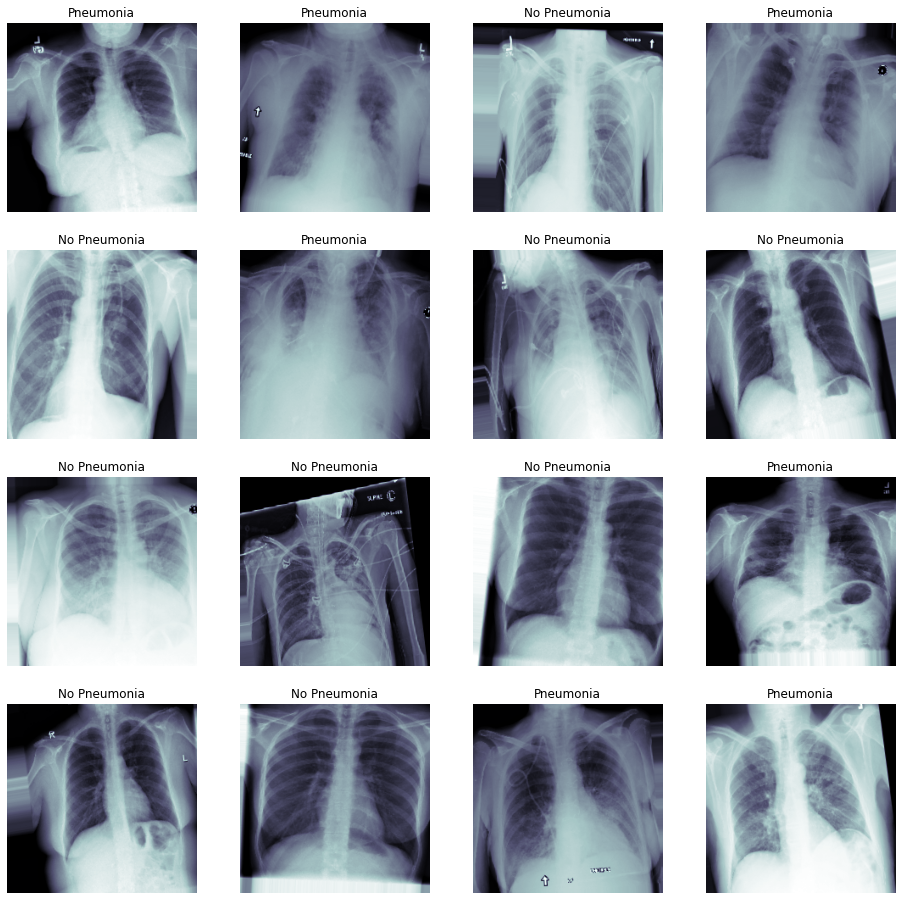

In [19]:
###### May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

train_idg = my_image_augmentation_train()
train_gen = make_train_gen(train_idg, train_data)

t_x, t_y = next(train_gen)
print("Batch Mean: " + str(t_x.mean()) + " Batch Std: " + str(t_x.std()))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network dwnloaded from Keras for fine-tuning

In [20]:
def load_pretrained_vgg_model(layer_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:-2]:
        layer.trainable = False
    
    return vgg_model


In [21]:
def build_my_model(pretrained_model):
    
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
#    my_model_history = my_model.fit_generator(train_gen, 
#                                             validation_data=(val_X, val_Y),
#                                             epochs=epochs)
    
    
    return my_model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [22]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

## Monitor Validation Binary accuracy, because the validation accuracy allows us to see if the model can be generalized
## to images that it wasn't trained on.  Validation accuracy is chosen over validation loss, because this problem
## is to detect Positive-Pneumonia or Negative-Pneumonia.

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [23]:
## train your model
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model = build_my_model(vgg_model)
history = my_model.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 10,
                           callbacks = callbacks_list)

553467904/553467096 [==============================] - 7s 0us/step
Epoch 1/10
144/144 [==============================] - 89s 618ms/step - loss: 0.7916 - binary_accuracy: 0.4978 - val_loss: 0.7739 - val_binary_accuracy: 0.3497

Epoch 00001: val_loss improved from inf to 0.77393, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
144/144 [==============================] - 73s 504ms/step - loss: 0.6917 - binary_accuracy: 0.5611 - val_loss: 0.4954 - val_binary_accuracy: 0.7399

Epoch 00002: val_loss improved from 0.77393 to 0.49537, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
144/144 [==============================] - 73s 505ms/step - loss: 0.6865 - binary_accuracy: 0.5559 - val_loss: 0.6599 - val_binary_accuracy: 0.7629

Epoch 00003: val_loss did not improve from 0.49537
Epoch 4/10
144/144 [==============================] - 73s 504ms/step - loss: 0.6853 - binary_accuracy: 0.5555 - val_loss: 0.7377 - val_binary_accuracy: 0.2622

Epoch 00004: val_loss did not improve from

In [24]:
def plot_history(history,epoch):
    plt.style.use('ggplot')
    plt.figure(figsize=(12,12))
    plt.style.use('ggplot')
    plt.plot(range(epoch),history.history['loss'],label='Loss', color='green')
    plt.plot(range(epoch),history.history['val_loss'],label='Validation_Loss', color = 'red')
    plt.plot(range(epoch),history.history['binary_accuracy'],label='Binary_Accuracy',color='blue')
    plt.plot(range(epoch),history.history['val_binary_accuracy'],label='Validation_Bin_Accuracy',color='purple')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.savefig('Model_Training_Performance')
    plt.show()

    return

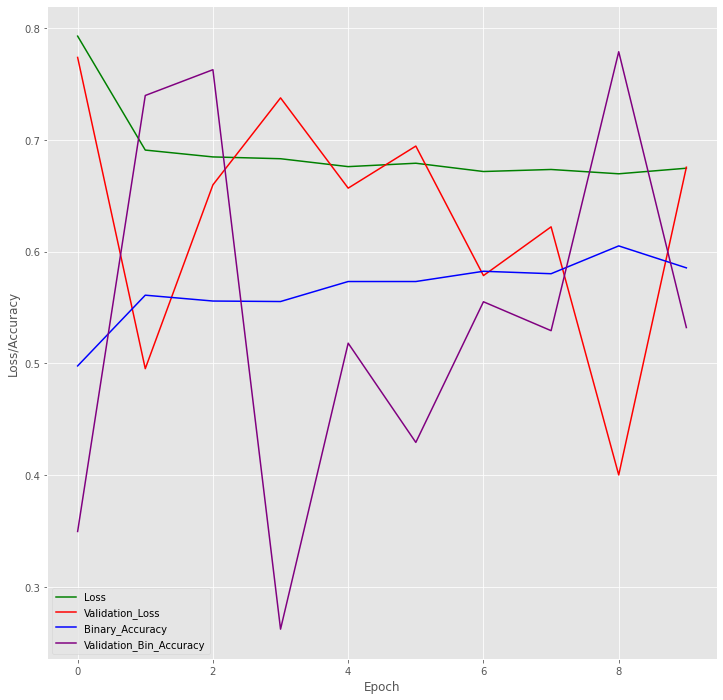

In [76]:
plot_history(history,10)

In [26]:
performance = []

In [27]:
history_df=pd.DataFrame(history.history)
performance.append(history_df[history_df['val_loss']==min(history_df['val_loss'])])
performance

[   val_loss  val_binary_accuracy      loss  binary_accuracy
 8  0.400249             0.779021  0.669773          0.60524]

In [28]:
def build_my_model2(pretrained_model):
    "Add one Dense layer and one Dropout Layer"
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(2048, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
     
    return my_model

In [29]:
#Train Model #2 with Dense and Dropout Layer
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model2 = build_my_model2(vgg_model)
history2 = my_model2.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 10,
                           callbacks = callbacks_list)

Epoch 1/10
144/144 [==============================] - 76s 527ms/step - loss: 0.8530 - binary_accuracy: 0.5017 - val_loss: 0.6996 - val_binary_accuracy: 0.5671

Epoch 00001: val_loss did not improve from 0.40025
Epoch 2/10
144/144 [==============================] - 72s 497ms/step - loss: 0.6953 - binary_accuracy: 0.5044 - val_loss: 0.6562 - val_binary_accuracy: 0.7993

Epoch 00002: val_loss did not improve from 0.40025
Epoch 3/10
144/144 [==============================] - 72s 497ms/step - loss: 0.6973 - binary_accuracy: 0.5223 - val_loss: 0.6137 - val_binary_accuracy: 0.4965

Epoch 00003: val_loss did not improve from 0.40025
Epoch 4/10
144/144 [==============================] - 72s 499ms/step - loss: 0.6957 - binary_accuracy: 0.5100 - val_loss: 0.6827 - val_binary_accuracy: 0.8000

Epoch 00004: val_loss did not improve from 0.40025
Epoch 5/10
144/144 [==============================] - 72s 497ms/step - loss: 0.6963 - binary_accuracy: 0.4965 - val_loss: 0.7240 - val_binary_accuracy: 0.20

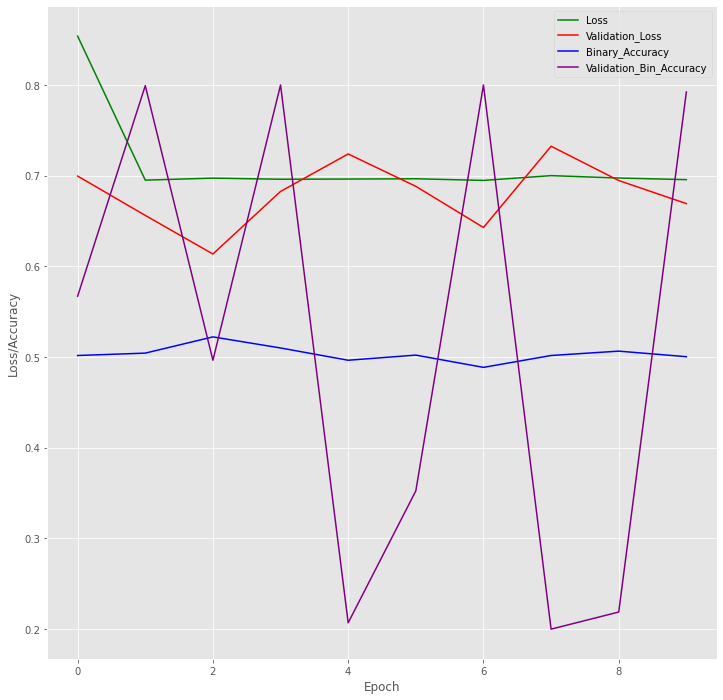

In [30]:
plot_history(history2,10)

In [31]:
history2_df=pd.DataFrame(history2.history)
performance.append(history2_df[history2_df['val_loss']==min(history2_df['val_loss'])])
performance

[   val_loss  val_binary_accuracy      loss  binary_accuracy
 8  0.400249             0.779021  0.669773          0.60524,
    val_loss  val_binary_accuracy      loss  binary_accuracy
 2  0.613657             0.496504  0.697323         0.522271]

In [32]:
def build_my_model3(pretrained_model):
    "Change Learning rate from 1e-3 to 1e-4"
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(2048, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
     
    return my_model

In [33]:
#Train Model3 
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model3 = build_my_model3(vgg_model)
history3 = my_model3.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 10,
                           callbacks = callbacks_list)

Epoch 1/10
144/144 [==============================] - 76s 531ms/step - loss: 0.8446 - binary_accuracy: 0.5210 - val_loss: 0.7323 - val_binary_accuracy: 0.3713

Epoch 00001: val_loss did not improve from 0.40025
Epoch 2/10
144/144 [==============================] - 72s 498ms/step - loss: 0.7093 - binary_accuracy: 0.5275 - val_loss: 0.7112 - val_binary_accuracy: 0.5371

Epoch 00002: val_loss did not improve from 0.40025
Epoch 3/10
144/144 [==============================] - 71s 494ms/step - loss: 0.7030 - binary_accuracy: 0.5341 - val_loss: 0.7736 - val_binary_accuracy: 0.4126

Epoch 00003: val_loss did not improve from 0.40025
Epoch 4/10
144/144 [==============================] - 71s 492ms/step - loss: 0.6795 - binary_accuracy: 0.5642 - val_loss: 0.6344 - val_binary_accuracy: 0.6441

Epoch 00004: val_loss did not improve from 0.40025
Epoch 5/10
144/144 [==============================] - 71s 491ms/step - loss: 0.6689 - binary_accuracy: 0.5943 - val_loss: 0.7700 - val_binary_accuracy: 0.54

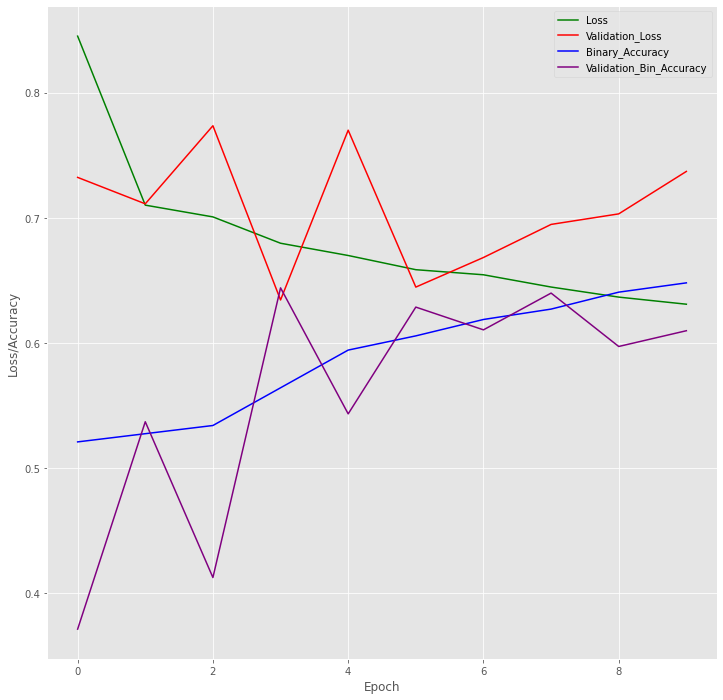

In [35]:
model3_plot = plot_history(history3,10)

In [36]:
history3_df=pd.DataFrame(history3.history)
performance.append(history3_df[history3_df['val_loss']==min(history3_df['val_loss'])])

In [37]:
performance

[   val_loss  val_binary_accuracy      loss  binary_accuracy
 8  0.400249             0.779021  0.669773          0.60524,
    val_loss  val_binary_accuracy      loss  binary_accuracy
 2  0.613657             0.496504  0.697323         0.522271,
    val_loss  val_binary_accuracy      loss  binary_accuracy
 3  0.634366             0.644056  0.679704         0.564192]

###### Model1 has the lowest val_loss.  Proceed with this model

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [39]:
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model1 = build_my_model(vgg_model)
my_model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)              

In [40]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

vgg_model = load_pretrained_vgg_model('block5_pool')
my_model1 = build_my_model(vgg_model)
my_model1.load_weights(weight_path)
val_gen.reset()
pred_Y = my_model1.predict(val_gen, verbose = True)   

45/45 [==============================] - 22s 479ms/step


In [41]:
pred_Y.shape

(1430, 1)

In [42]:
val_gen.labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [43]:
pred_Y = pred_Y.flatten().tolist()

In [44]:
predictions_df=pd.DataFrame({'Label':val_gen.labels,'Predict':pd.Series(pred_Y)})
predictions_df.sort_values('Label',ascending=False).head(10)

Label   Predict
0        1  0.193245
189      1  0.456418
195      1  0.421916
194      1  0.249468
193      1  0.270303
192      1  0.497541
191      1  0.437344
190      1  0.179173
188      1  0.349179
197      1  0.310833

In [45]:
predictions_df[predictions_df['Label']==1.0]

Label   Predict
0        1  0.193245
1        1  0.407833
2        1  0.248828
3        1  0.319503
4        1  0.306984
..     ...       ...
281      1  0.381869
282      1  0.272853
283      1  0.402572
284      1  0.179123
285      1  0.498377

[286 rows x 2 columns]

In [46]:
predictions_df.to_csv('Predictions_best_model.csv')

In [ ]:
#predictions_df= pd.read_csv('Predictions_best_model')
#predictions_df

In [47]:
def plot_roc(t_y, p_y):
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label = 1)
#    np.append(thresholds, 1)
    plt.plot(fpr,tpr)
    plt.style.use('ggplot')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Chance', alpha=.8)
    plt.savefig('ROC_Curve')
    plt.show()
    
    return fpr, tpr, thresholds

## what other performance statistics do you want to include here besides AUC? 


def plot_precision_recall_curve(t_y, p_y):
    precision, recall, threshold = precision_recall_curve(t_y,p_y,pos_label = 1)
    threshold = np.append(threshold, 1)
    plt.style.use('ggplot')
    plt.plot(precision, recall)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.savefig('Precision_Recall_Curve')
    plt.show()
    
    return precision, recall, threshold

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_f1(t_y,p_y):
    precision, recall, threshold = plot_precision_recall_curve(t_y,p_y)
    f1 = calc_f1(precision, recall)
    plt.style.use('ggplot')
    plt.plot(threshold, f1)
    plt.title('F1 vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1')
    plt.show()
    
    return precision, recall, f1, threshold

def plot_auc(t_y, p_y):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.style.use('ggplot')
    fpr, tpr, thresholds = plot_roc(t_y, p_y)
    res = auc(fpr, tpr)
    print("AUC-ROC is: " + str(res))
    return fpr, tpr, thresholds, res
    

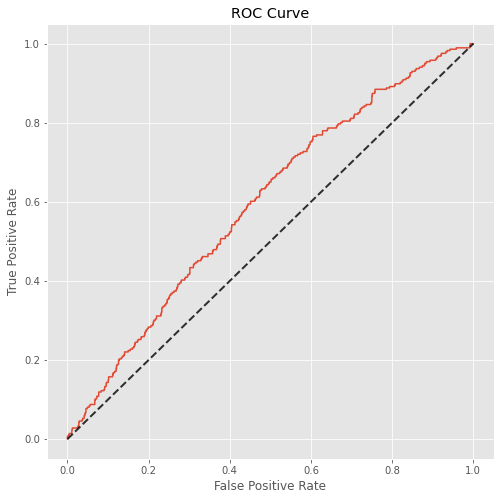

AUC-ROC is: 0.5959765758716808


In [48]:
fpr, tpr, thresholds_ROC, AUC = plot_auc(predictions_df['Label'],predictions_df['Predict'])


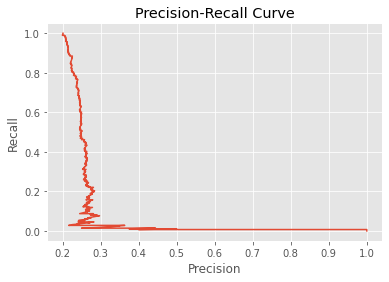

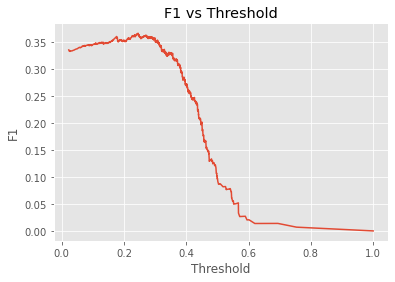

In [49]:
precision, recall, f1, thresholds_f1 = plot_f1(predictions_df['Label'],predictions_df['Predict'])

In [50]:
recall_df = pd.DataFrame({"Precision":precision, "Threshold":thresholds_f1, "Recall":recall, "F1":f1})

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [51]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

## If, this model can be used for screening studyies where High Recall is required, 
## reducing false negatives at the expense of more false positives.  This would 
## be found on the ROC curve where the distance away from Chance prediction is greatest.

def find_ROC_thresh(fpr,tpr,thresh):
    dist1=0
    dist2=0
    tprmax = 0
    for i in range(len(fpr)):
        dist2 = tpr[i] - fpr[i]
        if dist2 > dist1:
            dist1 = dist2
            tprmax=tpr[i]
        else:
            continue
    df = pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresh})
    threshmax = df['threshold'][df['tpr']==tprmax].iloc[-1]
    return threshmax

## If this model is used for confirming a diagnosis, high precision is desired.
## An F1 Score is maximized where there is a balance between precision and recall.
## The corresponding threshold for that F1 Score should be chosen.

def find_F1_thresh(f1,thresh):
    df = pd.DataFrame({'f1':f1,'threshold':thresh})
    threshmax = df['threshold'][df['f1']==df['f1'].max()].iloc[-1]
    return threshmax



In [52]:
thresh_ROC = find_ROC_thresh(fpr,tpr, thresholds_ROC)
print("thresh_ROC is " + str(thresh_ROC))

thresh_ROC is 0.24046292901039124


In [65]:
thresh_F1 = find_F1_thresh(f1, thresholds_f1)
print("thresh_F1 is " + str(thresh_F1))

thresh_F1 is 0.24509374797344208


In [66]:
val_gen_labels= pd.DataFrame(val_gen.labels)
val_Pos_labels= val_gen_labels[val_gen_labels[0] > 0]
val_Pos_labels
val_Pos_ind=val_Pos_labels.index
val_Pos_ind

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            276, 277, 278, 279, 280, 281, 282, 283, 284, 285],
           dtype='int64', length=286)

In [67]:
val_filenames = np.array(val_gen.filenames)
val_labels=np.array(val_gen.labels)

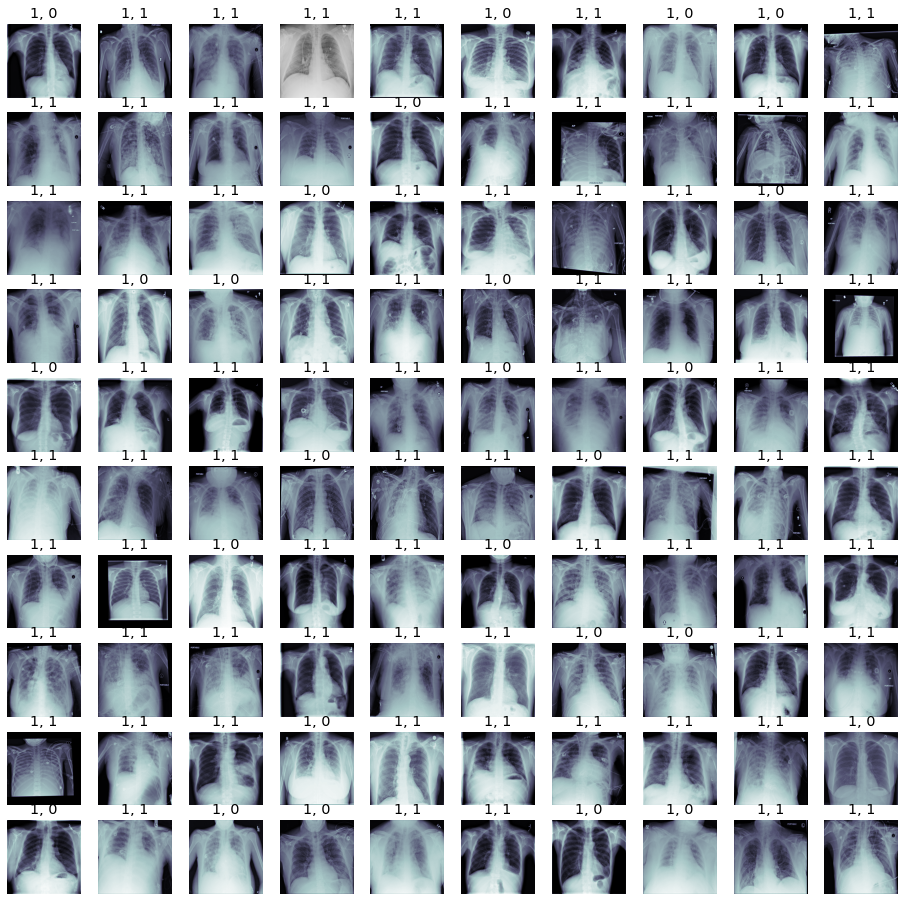

In [56]:
## Let's look at some examples of true vs. predicted with our best model based on thresh_ROC: 
Thresh=thresh_ROC

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_filenames[val_Pos_ind], val_labels[val_Pos_ind], m_axs.flatten()):
    c_ax.imshow(imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > Thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > Thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [57]:
#ROC Threshold Confusion Matrix:
pred_YROC = []

for x in range(len(pred_Y)):
    if pred_Y[x] > thresh_ROC:
        pred_YROC.append(1)
    else:
        pred_YROC.append(0)

tn,fp,fn,tp =confusion_matrix(val_gen.labels,pred_YROC).ravel()
print (tp, fp,"\n",fn,tn)

219 701 
 67 443


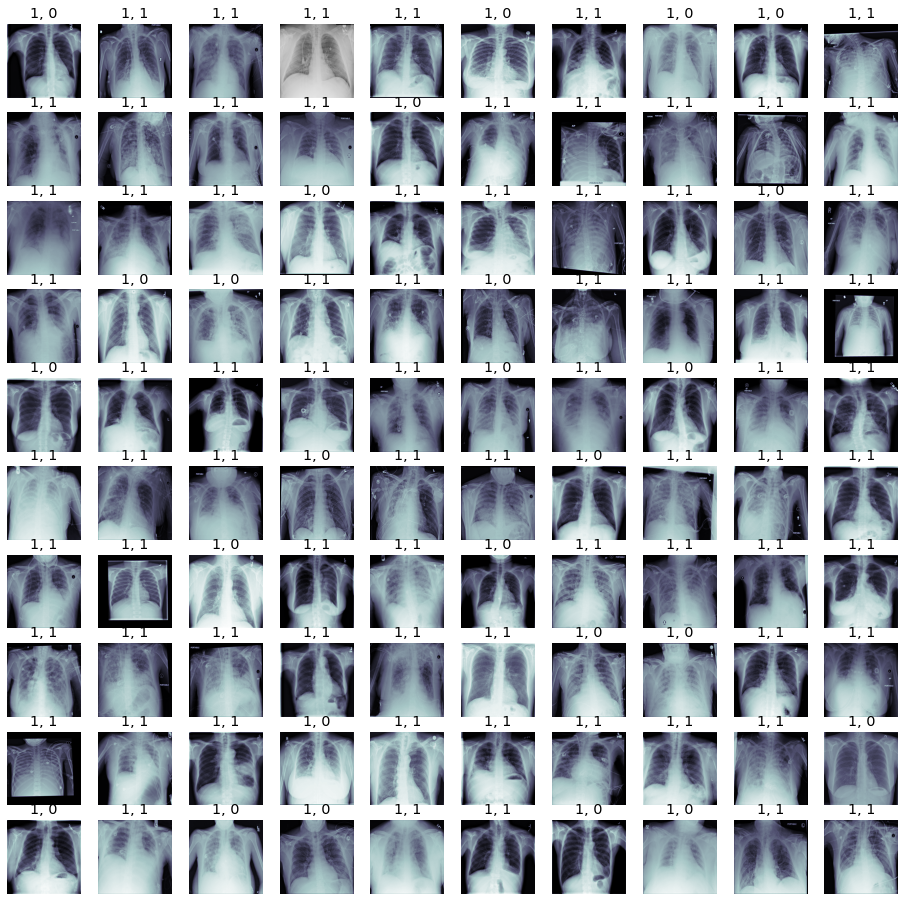

In [68]:
## Let's look at some examples of true vs. predicted with our best model based on thresh_F1: 
Thresh=thresh_F1

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_filenames[val_Pos_ind], val_labels[val_Pos_ind], m_axs.flatten()):
    c_ax.imshow(imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > Thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > Thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [69]:
#F1 Threshold Confusion Matrix:
pred_YF1 = []

for x in range(len(pred_Y)):
    if pred_Y[x] > thresh_F1:
        pred_YF1.append(1)
    else:
        pred_YF1.append(0)

tn,fp,fn,tp = confusion_matrix(val_gen.labels,pred_YF1).ravel()
print (tp, fp,"\n",fn,tn)

218 692 
 68 452


In [60]:
#Maximize Recall.  Choose Threshold at recall at 0.8.
recall_df[recall_df['Recall']>0.8]

Precision  Threshold    Recall        F1
0     0.201267   0.022725  1.000000  0.335091
1     0.200704   0.023171  0.996503  0.334115
2     0.200141   0.023793  0.993007  0.333138
3     0.200282   0.026170  0.993007  0.333333
4     0.199718   0.026187  0.989510  0.332355
..         ...        ...       ...       ...
418   0.228315   0.212396  0.800699  0.355314
419   0.228543   0.212438  0.800699  0.355590
420   0.228771   0.212824  0.800699  0.355866
421   0.229000   0.213011  0.800699  0.356143
422   0.229229   0.213210  0.800699  0.356420

[423 rows x 4 columns]

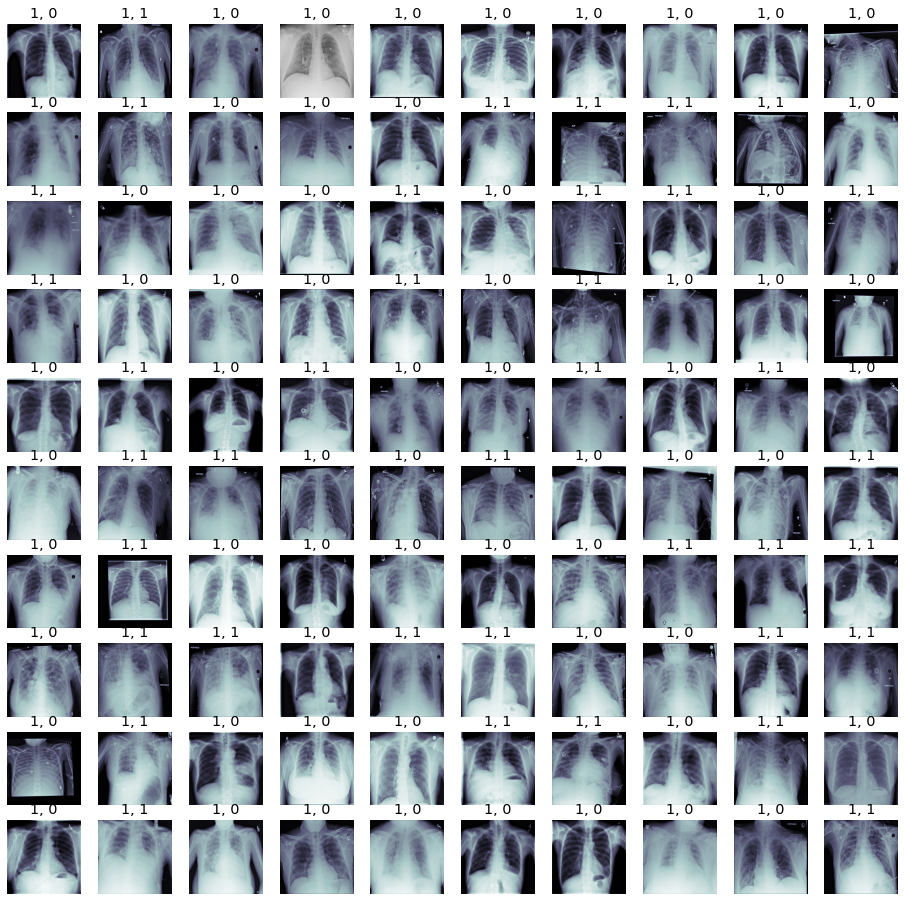

In [73]:
## Let's look at some examples of true vs. predicted with our best model maximizing Recall.  Recall=0.80: 
Thresh =  0.355

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_filenames[val_Pos_ind], val_labels[val_Pos_ind], m_axs.flatten()):
    c_ax.imshow(imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > Thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > Thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [74]:
thresh_recall = 0.355

pred_Yrecall = []

for x in range(len(pred_Y)):
    if pred_Y[x] > thresh_recall:
        pred_Yrecall.append(1)
    else:
        pred_Yrecall.append(0)

tn,fp,fn,tp = confusion_matrix(val_gen.labels,pred_Yrecall).ravel()
print (tp, fp,"\n",fn,tn)

124 351 
 162 793


#### The performance of three thresholds was explored by optimizing by ROC, by F1, and by maximizing Recall.  

#### 1.  Optimize Threshold value by ROC is seen above.  Based on images from the validation set with Positive Pneumonia labels, we see that the threshold value from ROC (0.24046) identifies some Positive Pneumonia labels correctly.  Based on it's corresponding confusion matrix, it yields 219 TP, 67 FN, 701 FP.

#### 2.  Optimize Threshold value by F1.  Based on images from the validation set with Positive Pneumonia labels, we see that the threshold value from F1 (0.24509) identifies some Positive Pneumonia labels correctly.  Based on it's corresponding confusion matrix, it yields 218 TP and 68 FN, 692 FP.  The performance is similar to optimizing by ROC.  With this threshold, the F1 score is 0.36.

#### 3.  Maximize recall.  A threshold value of 0.355 was chosen where Recall is above 0.80.  It's corresponding confusion matrix, it yields 124 TP, 162 FN, with 351 FP.  Though this method should have favored increasing TP at the cost of FN, this did not yield a result that is more aggressive that optimizing by ROC or F1.


#### For this project, model1 is the best architecture and its optimal threshold value is 0.24509 as determined from F1.  This combination yields a F1 score of 0.36.

In [75]:
## Just save model architecture to a .json:
model_json = my_model1.to_json()

with open("my_model1.json", "w") as json_file:
    json_file.write(model_json)